## 매 시도마다 돌릴 것들

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install datasets --quiet

import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

data_path = '/content/drive/MyDrive/Colab Notebooks/COSE474/MVSA/data/'  # 이미지 및 텍스트 파일 폴더

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from collections import Counter
from tqdm import tqdm
from collections import Counter
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoConfig
from scipy.special import softmax
import shutil
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import seaborn as sns
import torch.nn as nn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 전처리

In [2]:
# 텍스트 데이터 로드
texts_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/COSE474/MVSA/texts.csv', encoding='unicode_escape')
label_txt = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/COSE474/MVSA/label.txt', sep='\t', header=0)
label_txt.columns = ['ID', 'Annotator1', 'Annotator2', 'Annotator3']
label_jpg = label_txt.copy()

def pre_text(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

texts_df['Text'] = texts_df['Text'].apply(pre_text)

In [3]:
dic = {'positive': 1, 'neutral':0, 'negative': -1}
def pre_labeltext(text):
    new_text = text.split(",")[0]
    return dic[new_text]
label_txt['Annotator1'] = label_txt['Annotator1'].apply(pre_labeltext)
label_txt['Annotator2'] = label_txt['Annotator2'].apply(pre_labeltext)
label_txt['Annotator3'] = label_txt['Annotator3'].apply(pre_labeltext)
label_txt['label'] = label_txt['Annotator1'] + label_txt['Annotator2'] + label_txt['Annotator3']
label_txt['label'] = label_txt['label']/3
label_txt = label_txt.drop(['Annotator1', 'Annotator2', 'Annotator3'], axis=1)

In [4]:
def pre_labeltext(text):
    new_text = text.split(",")[1]
    return dic[new_text]
label_jpg['Annotator1'] = label_jpg['Annotator1'].apply(pre_labeltext)
label_jpg['Annotator2'] = label_jpg['Annotator2'].apply(pre_labeltext)
label_jpg['Annotator3'] = label_jpg['Annotator3'].apply(pre_labeltext)
label_jpg['label'] = label_jpg['Annotator1'] + label_jpg['Annotator2'] + label_jpg['Annotator3']
label_jpg['label'] = label_jpg['label']/3
label_jpg = label_jpg.drop(['Annotator1', 'Annotator2', 'Annotator3'], axis=1)

In [18]:
# 라벨 데이터와 텍스트 데이터 병합
merged_text = pd.merge(label_txt, texts_df, on='ID')

## 데이터 라벨링-모델 일치율 확인(만족스럽다)

In [6]:
def checksentiment(listtexts, listlabels):
    MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)
    model.to(device)
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    config = AutoConfig.from_pretrained(MODEL)
    batch_size = 16
    sentiment_scores = []

    for i in tqdm(range(0, len(listtexts), batch_size)):
        batch_texts = listtexts[i:i+batch_size]
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')
        encoded_input.to(device)

        with torch.no_grad():
            outputs = model(**encoded_input)

        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        scores = probabilities.cpu().numpy()

        pos_probs = scores[:, 2]  # 긍정 확률
        neg_probs = scores[:, 0]  # 부정 확률
        sentiments = pos_probs - neg_probs  # 감성 점수
        sentiment_scores.extend(sentiments)

    listlabels = np.array(listlabels)
    sentiment_scores = np.array(sentiment_scores)

    # L2 Loss
    l2_loss = np.mean((sentiment_scores - listlabels) ** 2)
    print(f"L2 Loss: {l2_loss}")

    return sentiment_scores

In [7]:
lab = merged_text['label'].tolist()
sentiment_scores = checksentiment(merged_text['Text'].tolist(), lab)
check = 0
for i in range(len(sentiment_scores)):
    if sentiment_scores[i] * lab[i] < 0:
        check+=1
check

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT e

L2 Loss: 0.22856436414728568


1713

## 이미지 설명-감성 분석 점수 확인(학습 전 저성능 확인)

In [8]:
#자기 전에 켜 둘 것
source_dir = '/content/drive/MyDrive/Colab Notebooks/COSE474/MVSA/data'

target_dir = '/content/data'

# 대상 폴더가 없으면 생성
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

loader = label_txt['ID'].tolist()

for filename in tqdm(loader):
    filename_with_ext = f"{filename}.jpg"
    src_file = os.path.join(source_dir, filename_with_ext)
    dst_file = os.path.join(target_dir, filename_with_ext)

    try:
        shutil.copy2(src_file, dst_file)
    except Exception as e:
        print(f"파일 복사 중 오류 발생: {filename_with_ext}, 오류: {e}")

100%|██████████| 19598/19598 [1:50:31<00:00,  2.96it/s]


In [10]:
len(sentiment_scores)

19593

In [20]:
merged = pd.merge(merged_text, label_jpg, on='ID')

In [23]:
merged = pd.merge(merged, label_txt, on='ID')

In [26]:
scores = np.array(sentiment_scores)
sim = merged['label_x'] * merged['label_y'] > 0
merged['pred'] = scores
input_df = merged[sim]

In [56]:
input_df.drop([1336], axis=0, inplace=True)

<ipython-input-56-a5e798a59b6a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df.drop([1336], axis=0, inplace=True)


In [58]:
image_dir = '/content/data'
def jpg(num):
    return f"{num}.jpg"
image_ids = input_df['ID'].apply(jpg).tolist()
actual_labels = input_df['pred'].tolist()
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model_blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")
model_blip.to(device)

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-23): 24 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (projection): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (layer_norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((1024,),

In [ ]:
captions = []

for image_id in tqdm(image_ids):

    image_path = os.path.join(image_dir, image_id)

    # 이미지 로드 및 전처리
    try:
        raw_image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"이미지 로드 실패: {image_id}, 오류: {e}")
        captions.append("")  # 빈 문자열 추가하여 인덱스 맞추기
        continue

    # 입력 데이터 생성
    inputs = processor(images=raw_image, return_tensors="pt").to(device)

    # 캡션 생성
    with torch.no_grad():
        out = model_blip.generate(**inputs)

    # 캡션 디코딩
    caption = processor.decode(out[0], skip_special_tokens=True)
    captions.append(caption)

  0%|          | 0/12850 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
  6%|▌         | 707/12850 [03:47<50:37,  4.00it/s]  

이미지 로드 실패: 3910.jpg, 오류: cannot identify image file '/content/data/3910.jpg'


 16%|█▌        | 2001/12850 [10:32<59:20,  3.05it/s]

이미지 로드 실패: 5995.jpg, 오류: cannot identify image file '/content/data/5995.jpg'


100%|██████████| 12850/12850 [1:09:18<00:00,  3.09it/s]


In [ ]:
sentiment_scores2 = checksentiment(captions, actual_labels)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 804/804 [00:08<00:00, 90.41it/s]

L2 Loss: 0.5017479144824811


In [ ]:
check = 0
for i in range(len(actual_labels)):
    if (abs(sentiment_scores2[i] - actual_labels[i]) > 0.4) or (sentiment_scores2[i] * actual_labels[i] < 0):
        check+=1
check

9873

<Axes: ylabel='Count'>

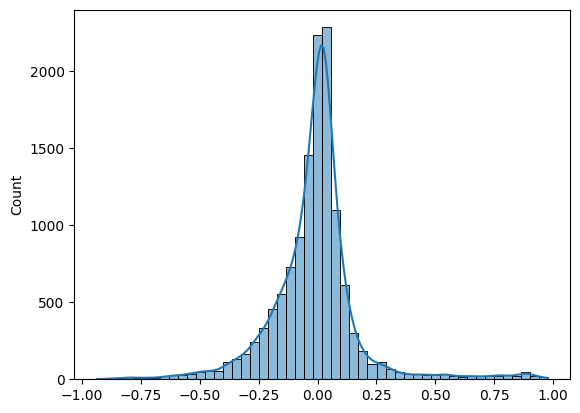

In [ ]:
sns.histplot(sentiment_scores, bins=50, kde=True)

## 멀티모달 이미지 감성-설명 학습

In [59]:
labels = actual_labels
image_dir = '/content/data'

In [60]:
class ImageDataset(Dataset):
    def __init__(self, image_ids, labels, image_dir, processor):
        self.image_ids = image_ids
        self.labels = labels
        self.image_dir = image_dir
        self.processor = processor

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        # 이미지 로드
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id)
        image = Image.open(image_path).convert('RGB')

        # 이미지 전처리
        inputs = self.processor(images=image, return_tensors="pt")

        pixel_values = inputs['pixel_values'].squeeze(0)  # [3, H, W]

        # 라벨 로드
        label = self.labels[idx]
        # 회귀 문제의 경우 실수형으로 변환
        label = torch.tensor(label, dtype=torch.float)

        return pixel_values, label


In [61]:
from sklearn.model_selection import train_test_split
train_image_ids, val_image_ids, train_labels, val_labels = train_test_split(
    image_ids, labels, test_size=0.1, random_state=42)

# BLIP 프로세서 로드
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")

# 데이터셋 및 데이터로더 생성
train_dataset = ImageDataset(train_image_ids, train_labels, image_dir, processor)
val_dataset = ImageDataset(val_image_ids, val_labels, image_dir, processor)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4)

In [62]:
# BLIP 모델 로드
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")
blip_model.to(device)
blip_model.train()  # 학습 모드


BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-23): 24 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (projection): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (layer_norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((1024,),

In [63]:
# 감성 분석 모델 로드 (고정된 상태로 사용)
MODEL_SA = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer_sa = AutoTokenizer.from_pretrained(MODEL_SA)
config_sa = AutoConfig.from_pretrained(MODEL_SA)
model_sa = AutoModelForSequenceClassification.from_pretrained(MODEL_SA)
model_sa.to(device)
model_sa.eval()  # 평가 모드

# 감성 분석 모델의 파라미터를 고정
for param in model_sa.parameters():
    param.requires_grad = False


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [64]:
# 손실 함수 정의 (예: MSELoss)
criterion = nn.MSELoss()

# 옵티마이저 정의 (BLIP 모델의 파라미터만 업데이트)
optimizer = torch.optim.AdamW(blip_model.parameters(), lr=1e-5)


In [65]:
num_epochs = 100  # 최대 에포크 수를 크게 설정
patience = 5      # 검증 손실이 개선되지 않는 에포크 수 허용치
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False


In [ ]:
for epoch in range(num_epochs):
    blip_model.train()
    total_loss = 0.0
    for pixel_values, labels in tqdm(train_dataloader):
        pixel_values = pixel_values.to(device)  # [batch_size, 3, H, W]
        labels = labels.to(device)  # [batch_size]

        # BLIP 모델을 통해 캡션 생성
        outputs = blip_model.generate(pixel_values=pixel_values, max_length=20)
        # 생성된 토큰 ID를 디코딩하여 텍스트로 변환
        captions = [processor.decode(output, skip_special_tokens=True) for output in outputs]

        # 감성 분석 모델을 통해 감성 점수 계산
        inputs_sa = tokenizer_sa(captions, return_tensors="pt", truncation=True, padding=True).to(device)
        with torch.no_grad():
            outputs_sa = model_sa(**inputs_sa)
        scores = outputs_sa.logits  # [batch_size, num_labels]

        # 감성 점수 계산 (pos_probs - neg_probs)
        scores = scores.cpu().numpy()
        probs = softmax(scores, axis=1)
        pos_probs = probs[:, 2]  # 긍정 확률
        neg_probs = probs[:, 0]  # 부정 확률
        sentiment_scores = pos_probs - neg_probs  # [batch_size]

        # 감성 점수를 텐서로 변환
        sentiment_scores = torch.tensor(sentiment_scores, dtype=torch.float).to(device)

        # 손실 계산 (예측된 감성 점수와 실제 라벨 간의 차이)
        loss = criterion(sentiment_scores, labels)
        loss.requires_grad_(True)
        # 역전파 및 옵티마이저 스텝
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # 검증 루프
    blip_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for pixel_values, labels in val_dataloader:
            pixel_values = pixel_values.to(device)
            labels = labels.to(device)

            outputs = blip_model.generate(pixel_values=pixel_values, max_length=20)
            captions = [processor.decode(output, skip_special_tokens=True) for output in outputs]

            inputs_sa = tokenizer_sa(captions, return_tensors="pt", truncation=True, padding=True).to(device)
            outputs_sa = model_sa(**inputs_sa)
            scores = outputs_sa.logits
            scores = scores.cpu().numpy()
            probs = softmax(scores, axis=1)
            pos_probs = probs[:, 2]
            neg_probs = probs[:, 0]
            sentiment_scores = pos_probs - neg_probs
            sentiment_scores = torch.tensor(sentiment_scores, dtype=torch.float).to(device)

            loss = criterion(sentiment_scores, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Early Stopping 체크
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # 최적의 모델 저장 (옵션)
        torch.save(blip_model.state_dict(), 'best_blip_model.pth')
        print("Validation loss improved. Model saved.")
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break


  8%|▊         | 217/2890 [02:11<27:19,  1.63it/s]